```
Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         10/02/2017
Name:         Jeff Kao
Worked with:  Jeff Kao... :-(
```

# Week 2 Challenge: Luther (pandas)

### Challenge 0

Scrape the data before we start

In [1]:
import requests
import re
import pandas as pd
import numpy as np
import string
from bs4 import BeautifulSoup

In [ ]:
#scrape boxoffice mojo
#i'm going to look @ movie data from the year 2000
base_url = 'http://www.boxofficemojo.com'
urls_list = ['http://www.boxofficemojo.com/yearly/chart/?page=1&view=releasedate&view2=domestic&yr=2000&p=.htm',
             'http://www.boxofficemojo.com/yearly/chart/?page=2&view=releasedate&view2=domestic&yr=2000&p=.htm',
             'http://www.boxofficemojo.com/yearly/chart/?page=3&view=releasedate&view2=domestic&yr=2000&p=.htm',
             'http://www.boxofficemojo.com/yearly/chart/?page=4&view=releasedate&view2=domestic&yr=2000&p=.htm'
            ]

In [ ]:
def get_movie_links(urls_list):
    movie_links = []
    for fullpath in urls_list:
        response = requests.get(fullpath)
        if response.status_code == 200:
            page_text = response.text
            soup = BeautifulSoup(page_text, "lxml")
            attributes = {"border" : "0",
                          "cellspacing" : "1",
                          "cellpadding" : "5",
                          "bgcolor" : "#ffffff"
                         }
            table = soup.find("table", attributes)
            movie_regex = re.compile('movies')
            tags = table.findAll('a', href=movie_regex)
            for tag in tags:
                if tag:
                    link = tag['href']
                    movie_links.append(link)
            print('Movie List Downloaded Successfully: {}'.format(fullpath))
        else:
            print('Movie List Download Failed: {}'.format(fullpath))
            return None
    return movie_links

In [ ]:
def get_movie_row(page_text):
    soup = BeautifulSoup(page_text, "lxml")
    # Title 
    title_table_attr = {"border":"0",
                        "cellpadding":"0",
                        "cellspacing":"0",
                        "width":"100%",
                        "style":"padding-top: 5px;"}
    title_table = soup.find("table", title_table_attr)
    inner_title_table_attr = {"border":"0",
                        "cellpadding":"4",
                        "cellspacing":"1",
                        "width":"95%",
                        "bgcolor":"#dcdcdc"}
    inner_title_table = title_table.find("table", inner_title_table_attr)
    inner_table_rows = inner_title_table.find_all('tr')

    title_font_attr = {"face":"Verdana"}
    title_font = title_table.find("font",title_font_attr)
    title = title_font.text
    # Budget 
    budget = np.nan
    budget_string = inner_table_rows[3].find_all("td")[1].text
    if budget_string.split(':')[1].strip() == 'N/A':
        pass
    else:
        budget =  float(budget_string              
                  .split('$')[1]
                  .replace('million','000000')
                  .replace(',','')
                  .replace(' ',''))
    # DomesticTotalGross 
    dtg_text = inner_table_rows[0].find_all("td")[0].text
    if 'Domestic Lifetime Gross' in dtg_text:
        dtg_text = dtg_text.split('Domestic Lifetime Gross')[0]
    dtg = int(dtg_text.split('$')[1].strip().replace(',',''))
    # Director 
    players_td_attr = {"valign":"top",
                        "style":"padding-left: 10px;"}
    players_td = soup.find("td", players_td_attr)
    director = ''
    try:
        director = players_td.find_all("tr")[0].find_all("td")[1].text
    except IndexError:
        pass
    # Rating 
    rating = inner_table_rows[3].find_all("td")[0].text.split(':')[1].strip()
    # Runtime 
    runtime_string = inner_table_rows[2].find_all("td")[1].text
    runtime = np.nan
    if 'N/A' not in runtime_string:
        runtime_hours = int(runtime_string.split(' ')[1])
        runtime_minutes = int(runtime_string.split(' ')[3])
        runtime = runtime_hours * 60 + runtime_minutes
    # ReleaseDate
    releasedate = inner_table_rows[1].find_all("td")[1].text.split(':')[1].strip()
    # put row together
    return [title,budget,dtg,director,rating,runtime,releasedate]

In [ ]:
movies_df = pd.DataFrame()
movie_links = get_movie_links(urls_list)
movie_fails = []
print('=== DOWNLOADING MOVIES ===')
for path in movie_links:
    fullpath = base_url + path
    response = requests.get(fullpath)
    if response.status_code == 200:
        new_df = [get_movie_row(response.text)]
        movies_df = movies_df.append(new_df)
        print('Movie Downloaded Successfully: {}'.format(fullpath))
    else:
        print('Movie Download Failed: {}'.format(fullpath))
        movie_fails.append(fullpath)
movies_df.reset_index(drop=True, inplace=True)
movies_df.columns=['title','budget','domestic_total_gross','director','rating','runtime','release_date']
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])
print('=== DOWNLOADING MOVIES COMPLETED! ===')
movies_df

In [ ]:
movies_df.to_csv('2000_movies.csv')

In [2]:
movies_df = pd.read_csv('2000_movies.csv', index_col=0, parse_dates=['release_date'])

### Challenge 1

Plot domestic total gross over time.

In [3]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 7 columns):
title                   374 non-null object
budget                  156 non-null float64
domestic_total_gross    374 non-null int64
director                246 non-null object
rating                  374 non-null object
runtime                 342 non-null float64
release_date            374 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 23.4+ KB


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

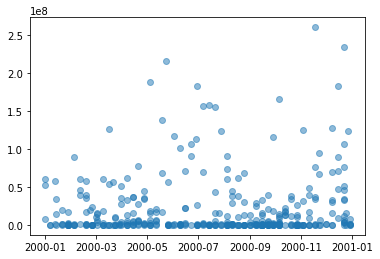

In [5]:
release_date_list = movies_df['release_date']
domestic_total_gross_list = movies_df['domestic_total_gross']
plt.plot_date(release_date_list, domestic_total_gross_list, alpha=0.5)
plt.show()

### Challenge 2

Plot runtime vs. domestic total gross.

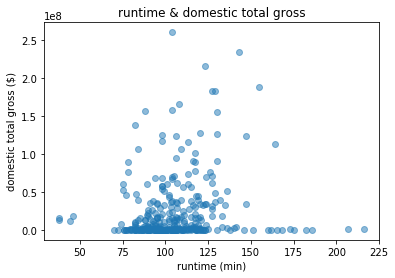

In [6]:
runtime_list = movies_df['runtime']
plt.scatter(runtime_list, domestic_total_gross_list, alpha=0.5)
plt.title('runtime & domestic total gross')
plt.xlabel('runtime (min)')
plt.ylabel('domestic total gross ($)');
plt.show()

### Challenge 3

Group your data by Rating and find the average runtime and domestic total gross at each level of Rating.

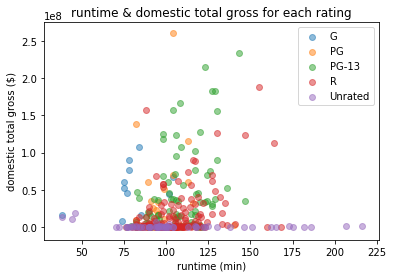

In [7]:
movies_grp_df = movies_df.groupby(['rating'])
handle_list = []
for index, group in movies_grp_df:
    handle = plt.scatter(group['runtime'], group['domestic_total_gross'], alpha=0.5, label=group['rating'].iloc[0])
    handle_list.append(handle)
plt.legend(handles=handle_list)
plt.title('runtime & domestic total gross for each rating')
plt.xlabel('runtime (min)')
plt.ylabel('domestic total gross ($)');
plt.show()

In [8]:
movies_grp_df.mean()

,budget,domestic_total_gross,runtime
rating,,,
G,5.714286e+07,3.439754e+07,84.235294
PG,4.594118e+07,3.591151e+07,99.259259
PG-13,4.980000e+07,4.552476e+07,108.350000
R,2.859714e+07,1.417581e+07,105.421384
Unrated,NaN,9.334758e+05,107.576271


### Challenge 4

Make one figure with (N=the number of MPAA ratings there are) subplots, and in each plot the release date vs the domestic total gross.

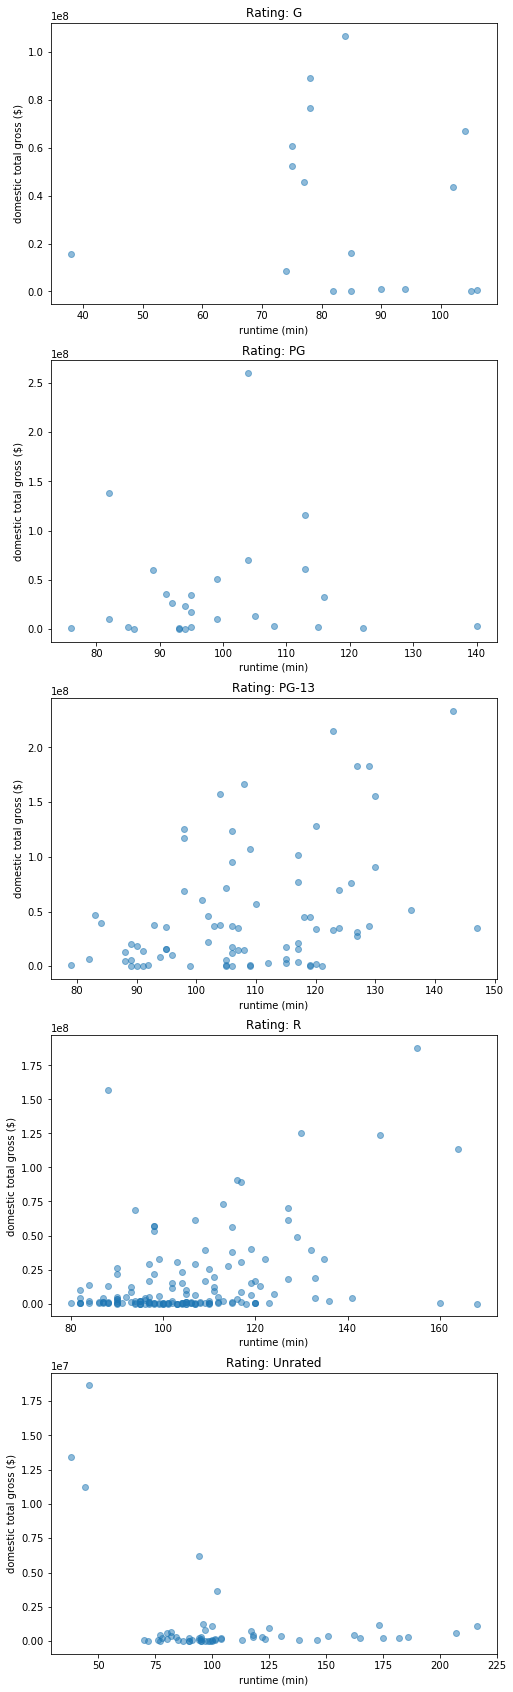

In [9]:
len(movies_grp_df)
fig = plt.figure(figsize=(8,30))
plotfig = 510
pltindex = 1
for index, group in movies_grp_df:
    ax = fig.add_subplot(plotfig + pltindex)
    ax.scatter(group['runtime'], group['domestic_total_gross'], alpha=0.5)
    pltindex += 1
    ax.set_title('Rating: {}'.format(group['rating'].iloc[0]))
    ax.set_xlabel('runtime (min)')
    ax.set_ylabel('domestic total gross ($)');
plt.show()

### Challenge 5

What director in your dataset has the highest gross per movie?

In [10]:
#TODO: fix director parser
director_gross_per_movie_df = movies_df.groupby(['director']).mean()

In [11]:
director_gross_per_movie_df.sort_values('domestic_total_gross', ascending=False).head()

,budget,domestic_total_gross,runtime
director,,,
Ron Howard,123000000.0,260044825.0,104.0
John Woo,125000000.0,215409889.0,123.0
Robert Zemeckis,95000000.0,194548246.5,136.5
Ridley Scott,103000000.0,187705427.0,155.0
Nancy Meyers,70000000.0,182811707.0,127.0


### Challenge 6

Bin your dataset into months and make a bar graph of the mean domestic total gross by month. Error bars will represent the standard error of the mean.

Title of graph should include: Mean Domestic Total Gross by Month in 2013

Topic for consideration: what is the correct formula for the standard error of the mean? Examine the error bars and see if they are "reasonable."

In [12]:
movies_df['release_month'] = movies_df['release_date'].apply(lambda x: x.month)

In [13]:
gross_by_month_movie_df = movies_df.groupby(['release_month']).mean()
gross_by_month_movie_stderr_df = movies_df.groupby(['release_month']).std()

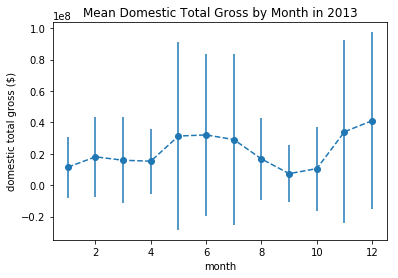

In [14]:
gross_by_month_movie_df
plt.errorbar(gross_by_month_movie_df.index, 
             gross_by_month_movie_df['domestic_total_gross'], 
             yerr=gross_by_month_movie_stderr_df['domestic_total_gross'], 
             fmt='--o')
plt.title('Mean Domestic Total Gross by Month in 2013')
plt.xlabel('month')
plt.ylabel('domestic total gross ($)');